# Image features exercise
We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [3]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from utils.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'utils/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
from utils.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code (You may have done this in the last assignment. So you only need to copy your answer to `utils/classifiers/linear_classifier.py` and `utils/classifiers/linear_svm.py`), train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength

from utils.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, lr, rs, num_iters=1000)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        training_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(lr,rs)] = (training_accuracy, validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm           

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

lr 1.000000e-09 reg 5.000000e+04 train accuracy: 0.101837 val accuracy: 0.077000
lr 1.000000e-09 reg 5.000000e+05 train accuracy: 0.091551 val accuracy: 0.090000
lr 1.000000e-09 reg 5.000000e+06 train accuracy: 0.097592 val accuracy: 0.093000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.089061 val accuracy: 0.091000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.109469 val accuracy: 0.090000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.410347 val accuracy: 0.412000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.324714 val accuracy: 0.296000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.411673 val accuracy: 0.412000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.384388 val accuracy: 0.403000
best validation accuracy achieved: 0.412000


In [8]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.421


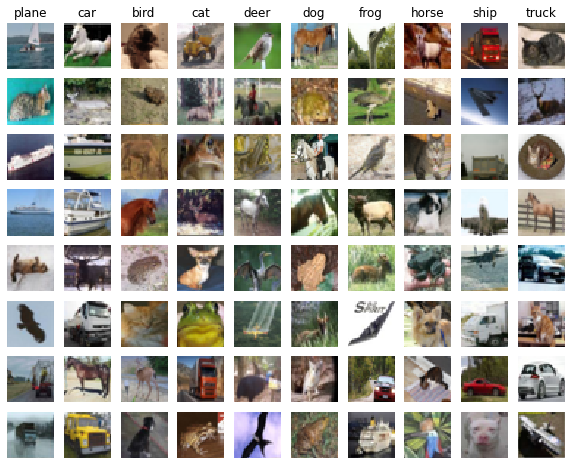

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$

由于采用方向梯度直方图和颜色直方图来提取特征，因此图像形状纹理和颜色相近时可能存在错分类情况，但这些错分类是有道理的。

比如plane类的第六张图，由于轮廓形似飞机机翼，因此被错分到plane类；frog类的第二张图，由于颜色以绿色为主，被错分到frog类。


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [10]:
from utils.classifiers.fc_net import TwoLayerNet
from utils.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats, 
    'y_train': y_train, 
    'X_val': X_val_feats, 
    'y_val': y_val, 
    'X_test': X_test_feats, 
    'y_test': y_test, 
}

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
data={
    "X_train": X_train_feats,
    "y_train": y_train,
    "X_val": X_val_feats,
    "y_val": y_val,
    "X_test": X_test_feats,
    "y_test": y_test,
}

weight_scale=1e-3
learning_rates = [1e-1, 5e-1]
regularization_strengths=[1e-3,5e-3]
batch_sizes=[200,100]
lr_decays=[0.95,0.9]
best_val=-1
results={}

for lr in learning_rates:
    for reg in regularization_strengths:
        for ld in lr_decays:
            for bs in batch_sizes:
                net = TwoLayerNet(input_dim, hidden_dim, num_classes)
                solver=Solver(net,data,update_rule='sgd',optim_config={'learning_rate':lr,},lr_decay=ld,num_epochs=10,batch_size=bs,print_every=100)
                solver.train()
                validation_accuracy=solver.best_val_acc
                training_accuracy=solver.best_val_acc
                results[(lr, reg, bs, ld)]=(validation_accuracy)
                if validation_accuracy>best_val:
                    best_val=validation_accuracy
                    best_net=net


# Print out results.
for lr, reg , bs, ld in sorted(results):
    validation_accuracy = results[(lr, reg, bs, ld)]
    print('lr:%e reg:%e batch_size:%f lr_decay:%e val accuracy: %f' % (lr, reg, bs, ld, validation_accuracy))
    
print('best validation accuracy: %f' % best_val)
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


(Iteration 1 / 2450) loss: 2.302534
(Epoch 0 / 10) train acc: 0.101000; val_acc: 0.105000
(Iteration 101 / 2450) loss: 2.249157
(Iteration 201 / 2450) loss: 1.729348
(Epoch 1 / 10) train acc: 0.390000; val_acc: 0.399000
(Iteration 301 / 2450) loss: 1.594163
(Iteration 401 / 2450) loss: 1.478767
(Epoch 2 / 10) train acc: 0.475000; val_acc: 0.498000
(Iteration 501 / 2450) loss: 1.398159
(Iteration 601 / 2450) loss: 1.484136
(Iteration 701 / 2450) loss: 1.459723
(Epoch 3 / 10) train acc: 0.507000; val_acc: 0.525000
(Iteration 801 / 2450) loss: 1.460708
(Iteration 901 / 2450) loss: 1.277412
(Epoch 4 / 10) train acc: 0.547000; val_acc: 0.515000
(Iteration 1001 / 2450) loss: 1.325160
(Iteration 1101 / 2450) loss: 1.197358
(Iteration 1201 / 2450) loss: 1.247247
(Epoch 5 / 10) train acc: 0.550000; val_acc: 0.527000
(Iteration 1301 / 2450) loss: 1.330997
(Iteration 1401 / 2450) loss: 1.210579
(Epoch 6 / 10) train acc: 0.593000; val_acc: 0.538000
(Iteration 1501 / 2450) loss: 1.218917
(Iteration

In [12]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.572
